In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearDiscriminantAnalysis as LDA, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [14]:
df = pd.read_csv('Bank_Transaction_Fraud_Detection.csv')
df.head()

,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email
0,d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e,Osha Tella,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,...,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,+9198579XXXXXX,Bitcoin transaction,oshaXXXXX@XXXXX.com
1,7c14ad51-781a-4db9-b7bd-67439c175262,Hredhaan Khosla,Female,51,Maharashtra,Nashik,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,...,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,+9191074XXXXXX,Grocery delivery,hredhaanXXXX@XXXXXX.com
2,3a73a0e5-d4da-45aa-85f3-528413900a35,Ekani Nazareth,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,...,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,+9197745XXXXXX,Mutual fund investment,ekaniXXX@XXXXXX.com
3,7902f4ef-9050-4a79-857d-9c2ea3181940,Yamini Ramachandran,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,...,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,+9195889XXXXXX,Food delivery,yaminiXXXXX@XXXXXXX.com
4,3a4bba70-d9a9-4c5f-8b92-1735fd8c19e9,Kritika Rege,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,...,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,+9195316XXXXXX,Debt repayment,kritikaXXXX@XXXXXX.com


In [15]:
df.shape

(200000, 24)

In [16]:
df.duplicated().sum()

0

### DATA PREPROCESSING

In [18]:
# Checking for missing values
print("Missing NULL values in the dataset:")
print(df.isnull().sum())
print("-"*80)
print("Missing N/A values in the dataset:")
print(df.isna().sum())

Missing NULL values in the dataset:
Customer_ID                0
Customer_Name              0
Gender                     0
Age                        0
State                      0
City                       0
Bank_Branch                0
Account_Type               0
Transaction_ID             0
Transaction_Date           0
Transaction_Time           0
Transaction_Amount         0
Merchant_ID                0
Transaction_Type           0
Merchant_Category          0
Account_Balance            0
Transaction_Device         0
Transaction_Location       0
Device_Type                0
Is_Fraud                   0
Transaction_Currency       0
Customer_Contact           0
Transaction_Description    0
Customer_Email             0
dtype: int64
--------------------------------------------------------------------------------
Missing N/A values in the dataset:
Customer_ID                0
Customer_Name              0
Gender                     0
Age                        0
State                  

In [19]:
desc = pd.DataFrame(index = list(df))
desc['type'] = df.dtypes
desc['count'] = df.count()
desc['nunique'] = df.nunique()
desc['%unique'] = desc['nunique'] /len(df) * 100
desc['null'] = df.isnull().sum()
desc['%null'] = desc['null'] / len(df) * 100
desc = pd.concat([desc,df.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='pink')

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
Age,int64,200000,53,0.026500,0,0.000000,44.015110,15.288774,18.000000,31.000000,44.000000,57.000000,70.000000
Is_Fraud,int64,200000,2,0.001000,0,0.000000,0.050440,0.218852,0.000000,0.000000,0.000000,0.000000,1.000000
Transaction_Amount,float64,200000,197978,98.989000,0,0.000000,49538.015554,28551.874004,10.290000,24851.345000,49502.440000,74314.625000,98999.980000
Account_Balance,float64,200000,197954,98.977000,0,0.000000,52437.988784,27399.507128,5000.820000,28742.395000,52372.555000,76147.670000,99999.950000
Customer_ID,object,200000,200000,100.000000,0,0.000000,nan,nan,nan,nan,nan,nan,nan
Customer_Name,object,200000,142699,71.349500,0,0.000000,nan,nan,nan,nan,nan,nan,nan
Gender,object,200000,2,0.001000,0,0.000000,nan,nan,nan,nan,nan,nan,nan
State,object,200000,34,0.017000,0,0.000000,nan,nan,nan,nan,nan,nan,nan
City,object,200000,145,0.072500,0,0.000000,nan,nan,nan,nan,nan,nan,nan
Bank_Branch,object,200000,145,0.072500,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [20]:
# Get a list of categorical columns in the dataframe
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

# If a column has only one unique value, it won't be useful for prediction.
single_value_columns = [col for col in df.columns if df[col].nunique() == 1]
print("Columns with only one unique value:", single_value_columns)

# Dropping columns with one unique value
df = df.drop(columns=single_value_columns)

# Checking columns after dropping one unique columns
df.columns

Index(['Customer_ID', 'Customer_Name', 'Gender', 'State', 'City',
       'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date',
       'Transaction_Time', 'Merchant_ID', 'Transaction_Type',
       'Merchant_Category', 'Transaction_Device', 'Transaction_Location',
       'Device_Type', 'Transaction_Currency', 'Customer_Contact',
       'Transaction_Description', 'Customer_Email'],
      dtype='object')
Columns with only one unique value: ['Transaction_Currency']


Index(['Customer_ID', 'Customer_Name', 'Gender', 'Age', 'State', 'City',
       'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date',
       'Transaction_Time', 'Transaction_Amount', 'Merchant_ID',
       'Transaction_Type', 'Merchant_Category', 'Account_Balance',
       'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Is_Fraud',
       'Customer_Contact', 'Transaction_Description', 'Customer_Email'],
      dtype='object')

In [21]:
# Drop the columns which are not useful for the model evaluation
df = df.drop(columns=['Customer_Contact', 'Customer_Email', 'Customer_Name', 'Customer_ID', 'Transaction_ID', 'Merchant_ID'])
print(df.shape)

(200000, 17)


### EXPLORATORY DATA ANALYSIS (EDA)

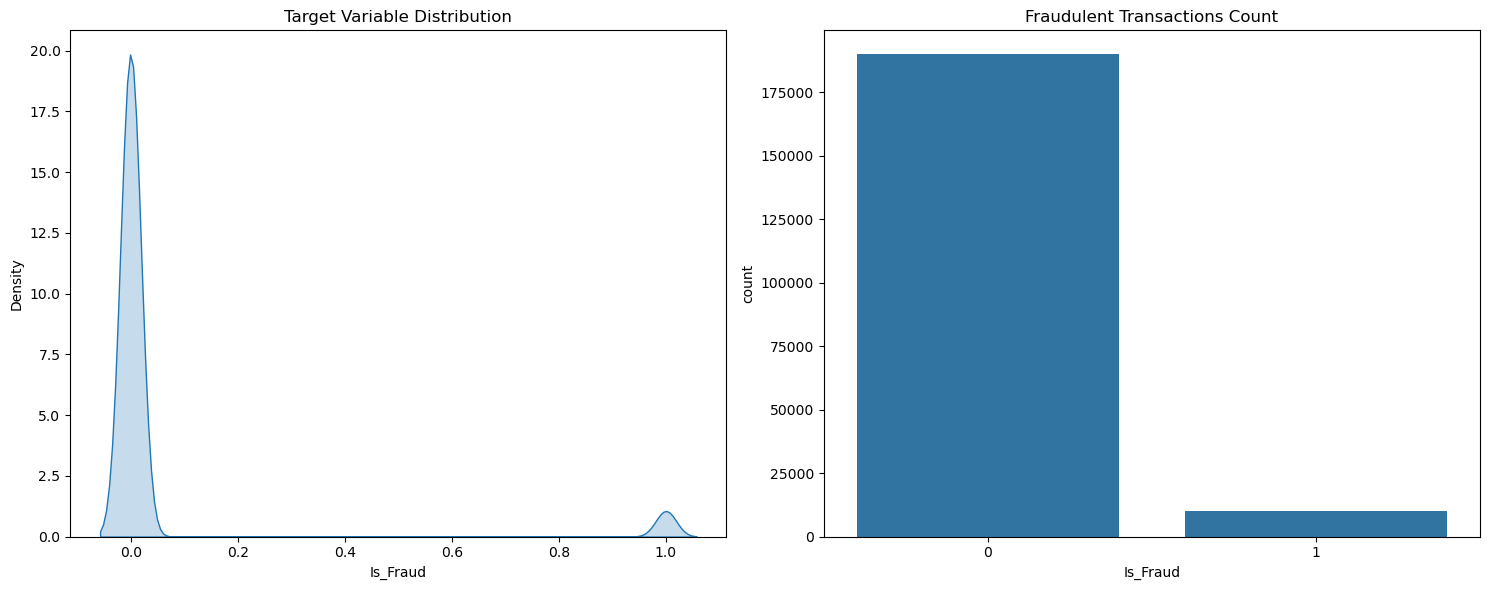

In [23]:
# No missing value, good luck
# Create a figure with 2 subplots in a horizontal row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# KDE plot for the 'Is_Fraud' column (on the first subplot)
sns.kdeplot(df["Is_Fraud"], fill=True, ax=axes[0])
axes[0].set_title('Target Variable Distribution')

# Count plot for the 'Is_Fraud' column (on the second subplot)
sns.countplot(x='Is_Fraud', data=df, ax=axes[1])
axes[1].set_title('Fraudulent Transactions Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

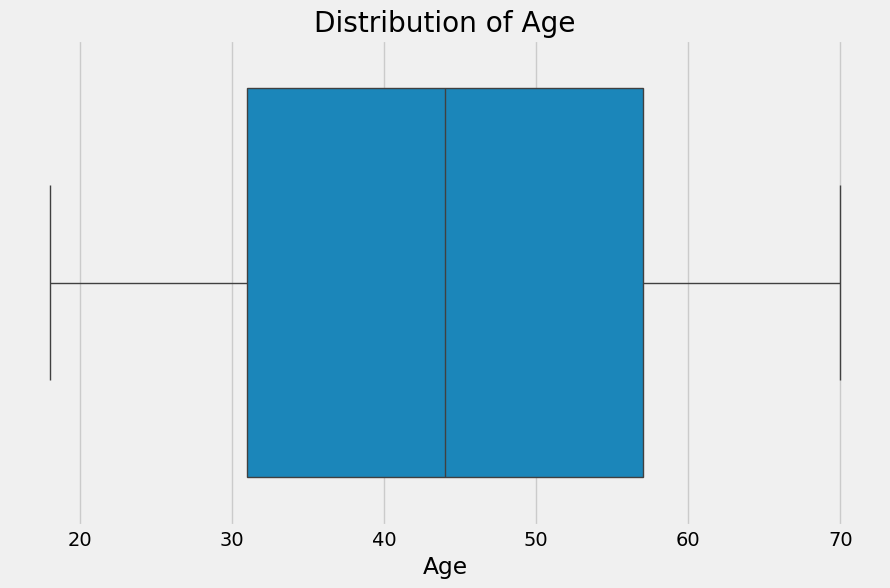

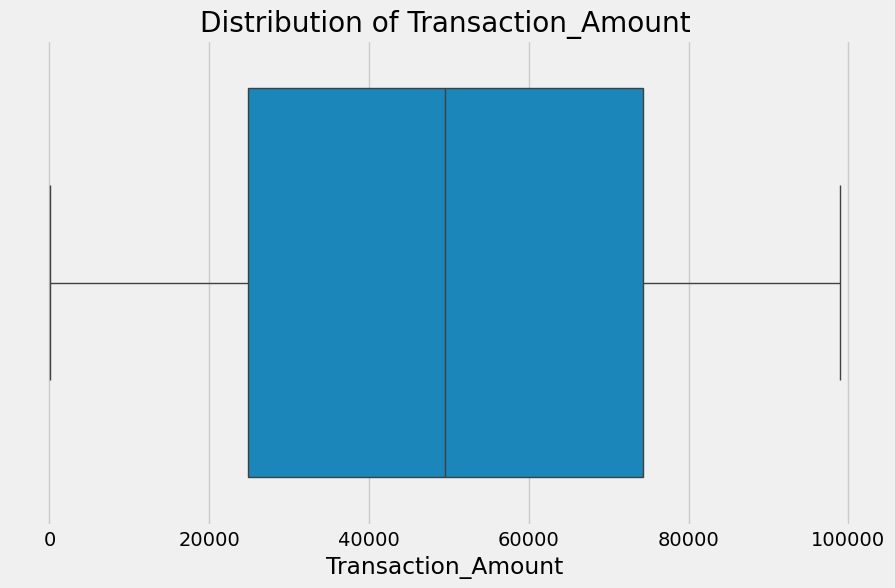

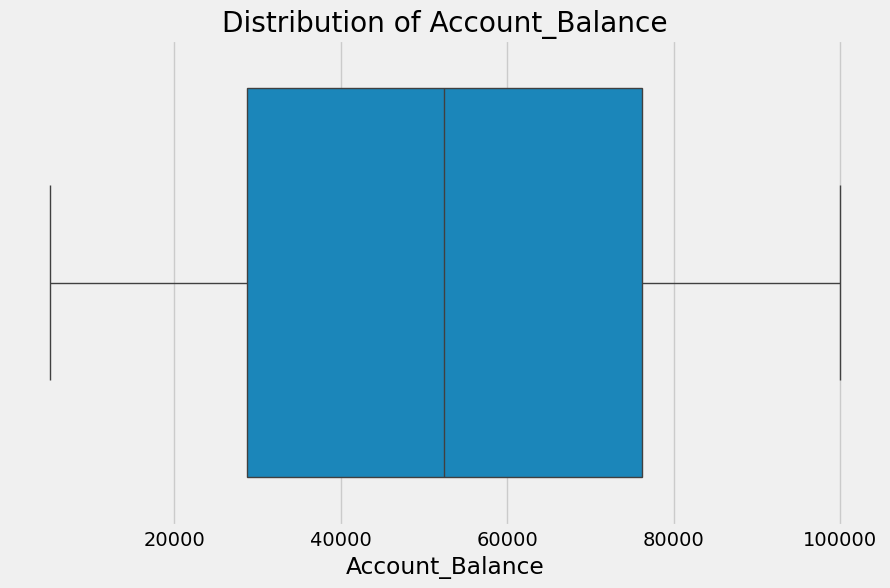

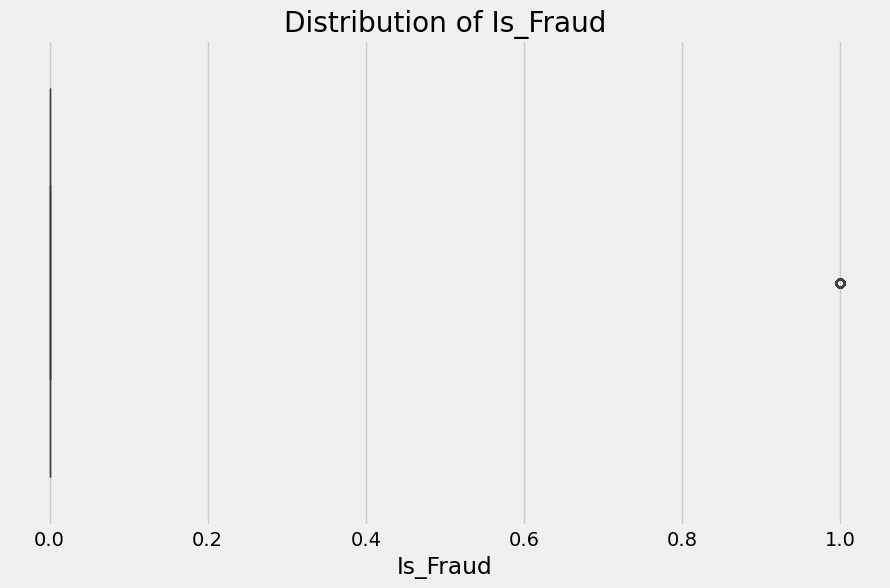

In [24]:
# Loop through each numerical column in the DataFrame

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(10, 6))
    
    # Create the boxplot
    sns.boxplot(x=df[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    
    # Show the plot
    plt.show()

### EDA FOR CATEGORICAL COLUMNS

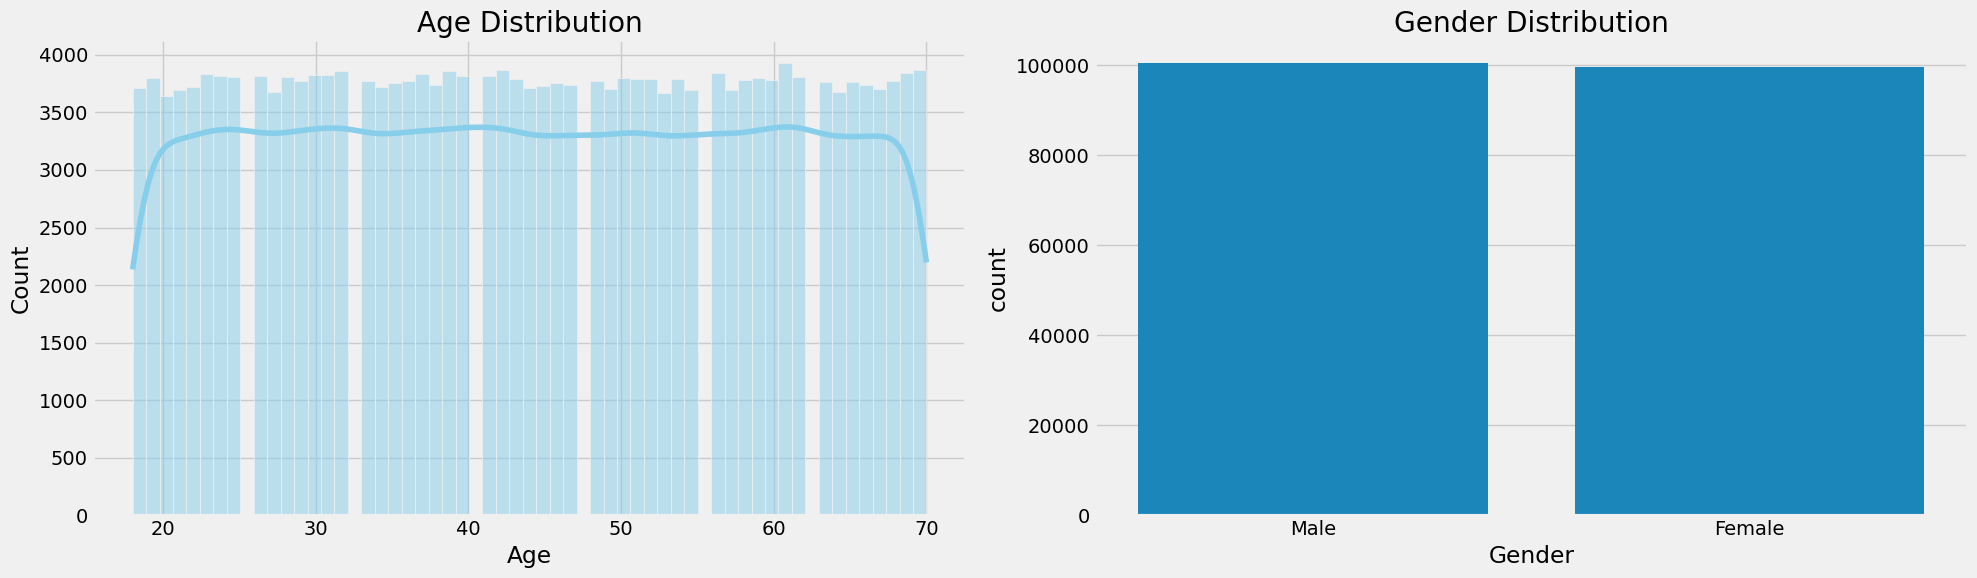

In [26]:
# No missing values for categorical columns, GOOD LUCK
categorical_columns = df.select_dtypes(include=['object']).columns
# Create a figure with 4 subplots in a horizontal row
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 4 columns

# Histogram for the 'Age' column (on the third subplot)
sns.histplot(df['Age'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Age Distribution')

# Count plot for the 'Gender' column (on the fourth subplot)
sns.countplot(x='Gender', data=df, ax=axes[1])
axes[1].set_title('Gender Distribution')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


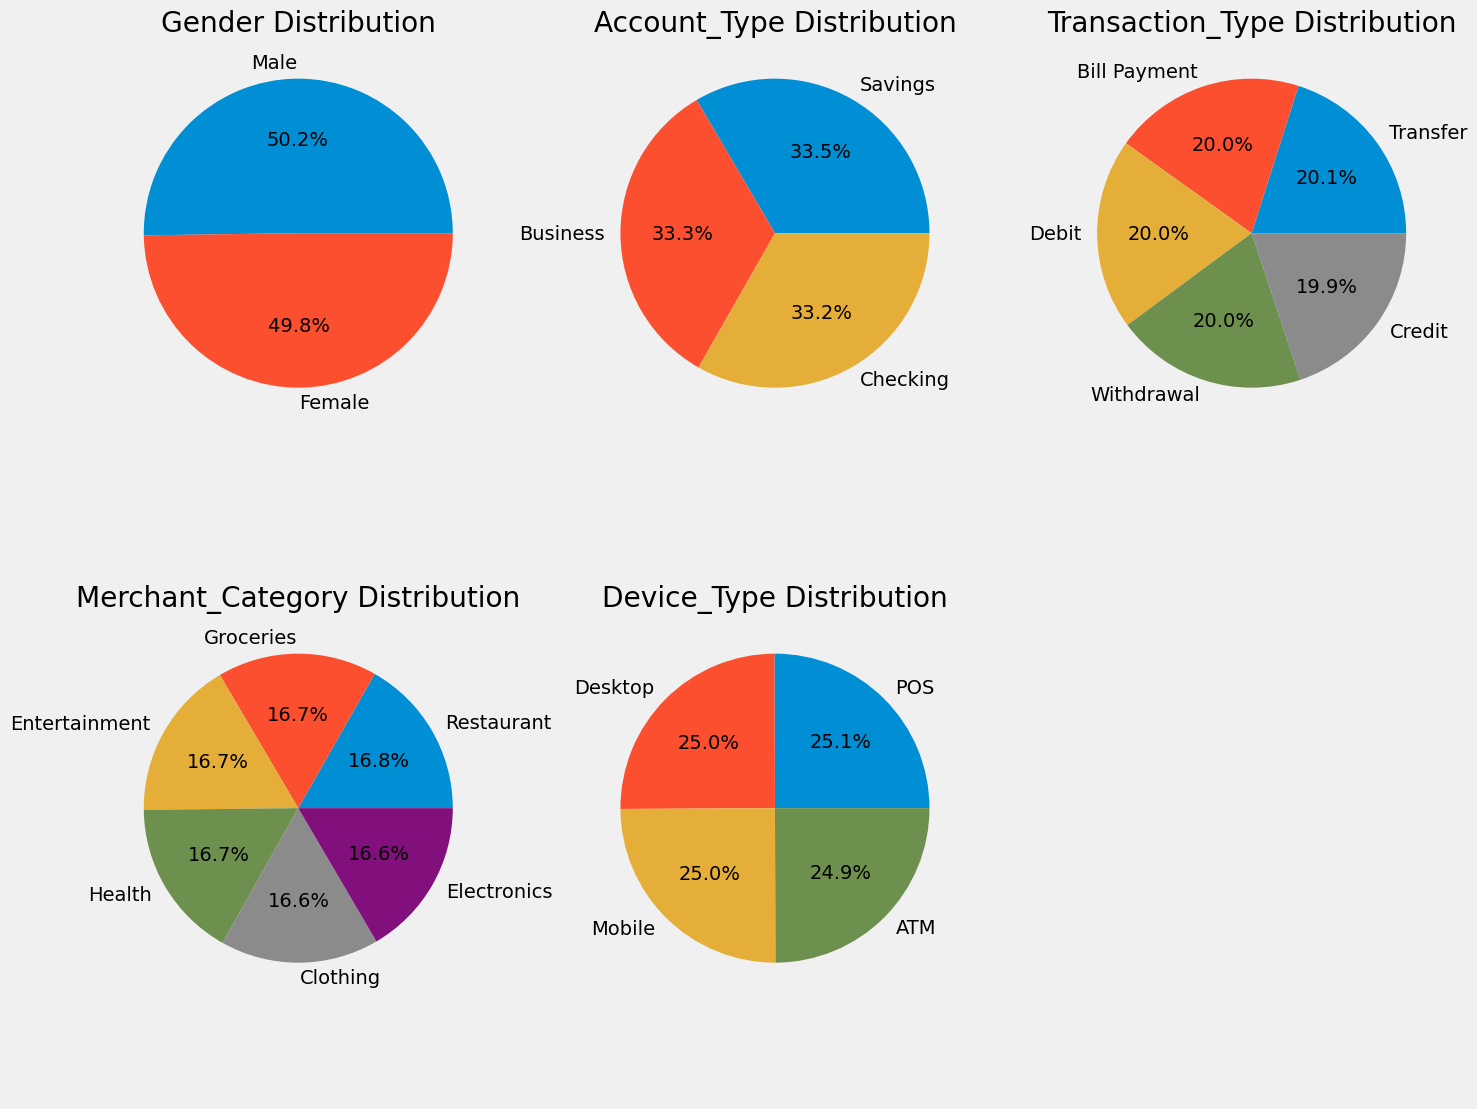

In [27]:
# Calculate the number of rows needed based on the number of charts
num_cols = 3  # Number of charts per row
# num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculate rows required for all charts
num_rows = 2 # Number of rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))  # Adjust figure size for more rows

# Flatten the axes array for easier iteration
axes = axes.flatten()

ax_index = 0
for col in categorical_columns:
    unique_values = df[col].nunique()
    if unique_values < 10:  # Only plot if unique values are less than 10
        # Plot on the respective subplot
        ax = axes[ax_index]
        ax.pie(df[col].value_counts(), labels=df[col].unique(), autopct='%1.1f%%')
        ax.set_title(f'{col} Distribution')
        
        # Move to the next subplot
        ax_index += 1

# Hide any unused subplots (in case there are fewer than `num_rows * num_cols` charts)
for i in range(ax_index, len(axes)):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

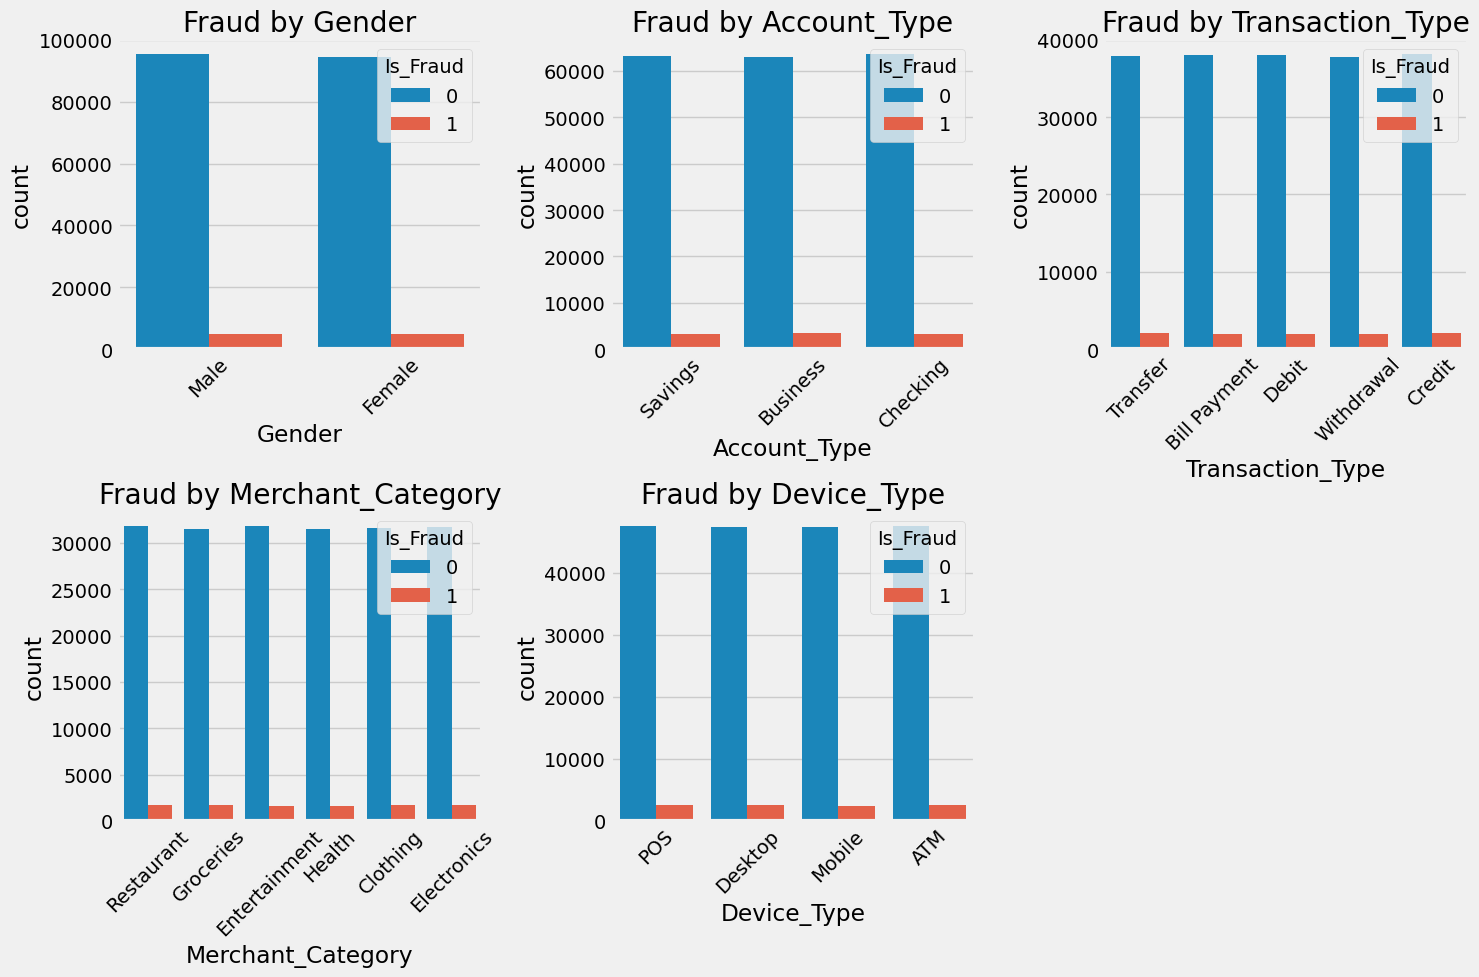

\Fraud Rate by Categories:

Gender Analysis:
Gender
Female    5.0
Male      5.1
Name: Is_Fraud, dtype: float64

Account_Type Analysis:
Account_Type
Business    5.2
Checking    4.9
Savings     5.0
Name: Is_Fraud, dtype: float64

Transaction_Type Analysis:
Transaction_Type
Bill Payment    4.9
Credit          5.1
Debit           5.1
Transfer        5.2
Withdrawal      4.9
Name: Is_Fraud, dtype: float64

Merchant_Category Analysis:
Merchant_Category
Clothing         5.2
Electronics      5.0
Entertainment    4.8
Groceries        5.2
Health           5.0
Restaurant       5.0
Name: Is_Fraud, dtype: float64

Device_Type Analysis:
Device_Type
ATM        5.0
Desktop    5.1
Mobile     5.0
POS        5.1
Name: Is_Fraud, dtype: float64


In [28]:
# Filter categorical columns with less than 20 unique values
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if df[col].nunique() < 20]

# Set the number of charts per row and rows
num_cols = 3  # Number of charts per row
num_rows = 2  # Number of rows

# Calculate the total number of subplots needed
total_plots = len(categorical_cols)

# Create a figure with the appropriate number of rows and columns
plt.figure(figsize=(15, 5 * num_rows))

# Plot the count plots for the filtered categorical columns
for i, col in enumerate(categorical_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(data=df, x=col, hue='Is_Fraud') 
    plt.title(f'Fraud by {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate churn rate by categories
print("\Fraud Rate by Categories:")
for col in categorical_cols:
    print(f"\n{col} Analysis:")
    print(df.groupby(col)['Is_Fraud'].mean().round(3) * 100)

### Convert Date Time Columns to Numerical Columns 

In [30]:
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], format='%d-%m-%Y')
df['Transaction_Time'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S')

In [31]:
# Extract new features from 'Transaction_Date' and 'Transaction_Time'
df['Transaction_Day'] = df['Transaction_Date'].dt.day
df['Transaction_Month'] = df['Transaction_Date'].dt.month
df['Transaction_Year'] = df['Transaction_Date'].dt.year
df['Transaction_Hour'] = df['Transaction_Time'].dt.hour
df['Transaction_Minute'] = df['Transaction_Time'].dt.minute
df['Transaction_Second'] = df['Transaction_Time'].dt.second

In [32]:
# Drop 'Transaction_Date' and 'Transaction_Time' columns after feature extraction
df = df.drop(columns=['Transaction_Date', 'Transaction_Time'])

In [33]:
# If a categorical column has only one unique value, it won't be useful for prediction.
single_value_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Columns with only one unique value:", single_value_columns)

# Dropping columns with one unique value
df = df.drop(columns=single_value_cols)

Columns with only one unique value: ['Transaction_Currency']


In [34]:
# Checking the updated numerical columns after conversion
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
print("Numerical Columns ::", numerical_columns)
print("-"*50)
# Checking the updated categorical columns after conversion
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical Columns ::", categorical_columns)

Numerical Columns :: Index(['Age', 'Transaction_Amount', 'Account_Balance', 'Is_Fraud'], dtype='object')
--------------------------------------------------
Categorical Columns :: Index(['Gender', 'State', 'City', 'Bank_Branch', 'Account_Type',
       'Transaction_Type', 'Merchant_Category', 'Transaction_Device',
       'Transaction_Location', 'Device_Type', 'Transaction_Description'],
      dtype='object')


In [35]:
# checking data state
df.head(7)

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Description,Transaction_Day,Transaction_Hour,Transaction_Minute,Transaction_Second
0,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,32415.45,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,Bitcoin transaction,23,16,4,7
1,Female,51,Maharashtra,Nashik,Nashik Branch,Business,43622.60,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,Grocery delivery,11,17,14,53
2,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,63062.56,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,Mutual fund investment,25,3,9,52
3,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,14000.72,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,Food delivery,19,12,27,2
4,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,18335.16,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,Debt repayment,30,18,30,46
5,Male,54,Gujarat,Ahmedabad,Ahmedabad Branch,Checking,9711.15,Transfer,Entertainment,61258.85,Mobile Device,"Ahmedabad, Gujarat",POS,0,Seminar registration,25,6,49,53
6,Female,61,Delhi,New Delhi,New Delhi Branch,Business,94677.01,Transfer,Health,36313.61,Payment Gateway Device,"New Delhi, Delhi",Desktop,0,Public transport pass,4,0,53,33


### ENCODING CATEGORICAL FEATURES

In [37]:
label_encoder = LabelEncoder()

In [38]:
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [39]:
# checking data state
df.head(7)

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Description,Transaction_Day,Transaction_Hour,Transaction_Minute,Transaction_Second
0,1,60,15,127,127,2,32415.45,3,5,74557.27,17,129,3,0,9,23,16,4,7
1,0,51,18,100,100,0,43622.60,0,5,74622.66,9,102,1,0,65,11,17,14,53
2,1,20,4,13,13,2,63062.56,0,3,66817.99,0,13,1,0,102,25,3,9,52
3,0,57,28,22,22,0,14000.72,2,2,58177.08,8,24,2,0,51,19,12,27,2
4,0,43,25,7,7,2,18335.16,3,2,16108.56,16,7,2,0,37,30,18,30,46
5,1,54,10,2,2,1,9711.15,3,2,61258.85,7,2,3,0,131,25,6,49,53
6,0,61,8,102,102,0,94677.01,3,4,36313.61,11,104,1,0,126,4,0,53,33


### Plot Correlation Matrix to Understand Feature Relationships

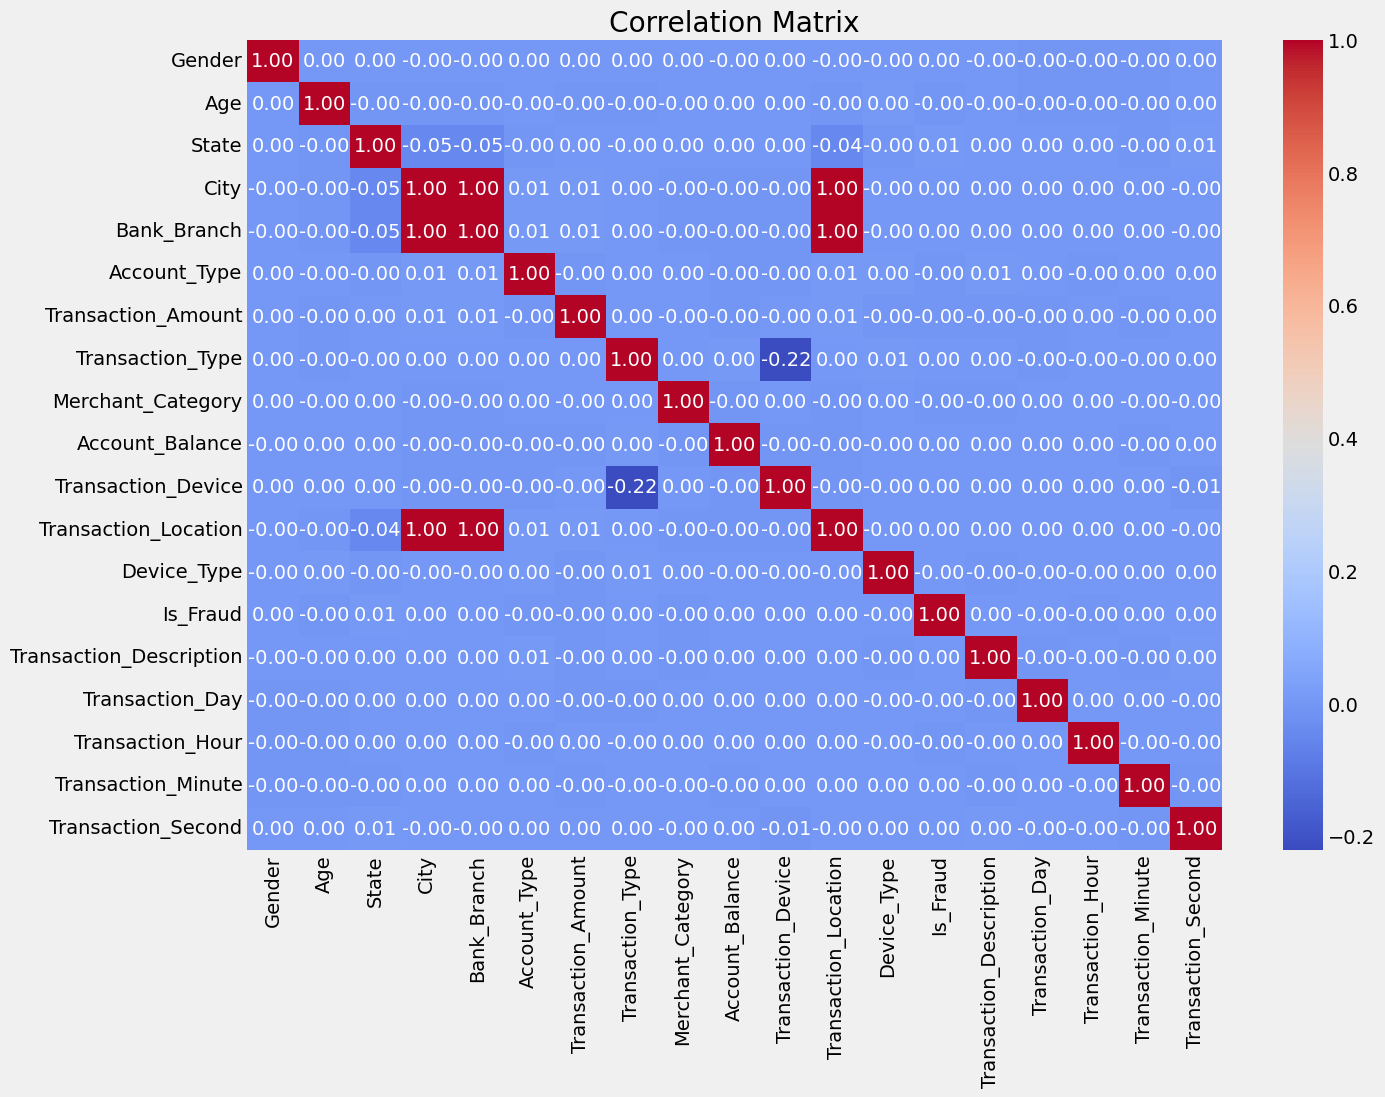

In [41]:
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

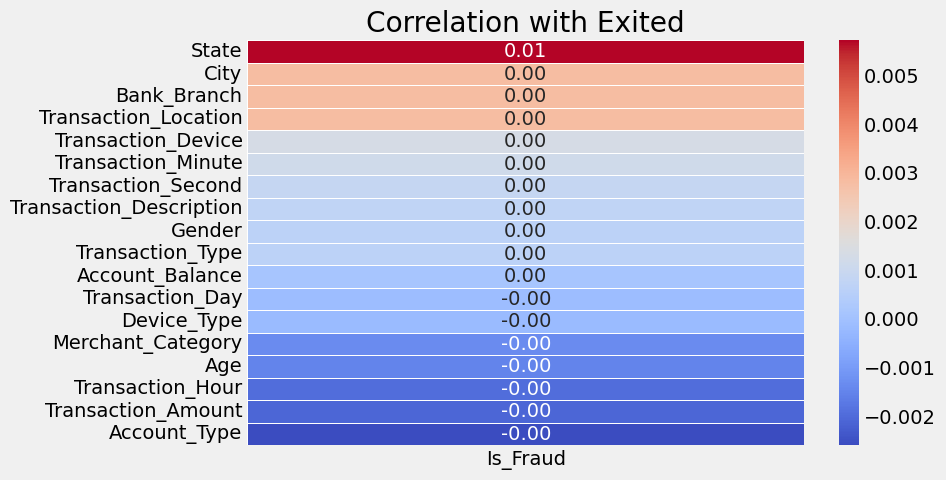

In [42]:
# Calculate correlation matrix for numerical columns
correlation_matrix = df.corr()

# Extract correlation with 'Exited' and drop 'Exited' itself
correlation_price = correlation_matrix['Is_Fraud'].sort_values(ascending=False).drop('Is_Fraud')

# Plot the heatmap for the correlation with 'Exited'
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_price.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation with Exited')
plt.show()

### Feature Importance using Random Forest

In [44]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X = df.drop(columns=['Is_Fraud'])
y = df['Is_Fraud']

In [45]:
# Train the model
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [46]:
# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

<Figure size 1200x800 with 0 Axes>

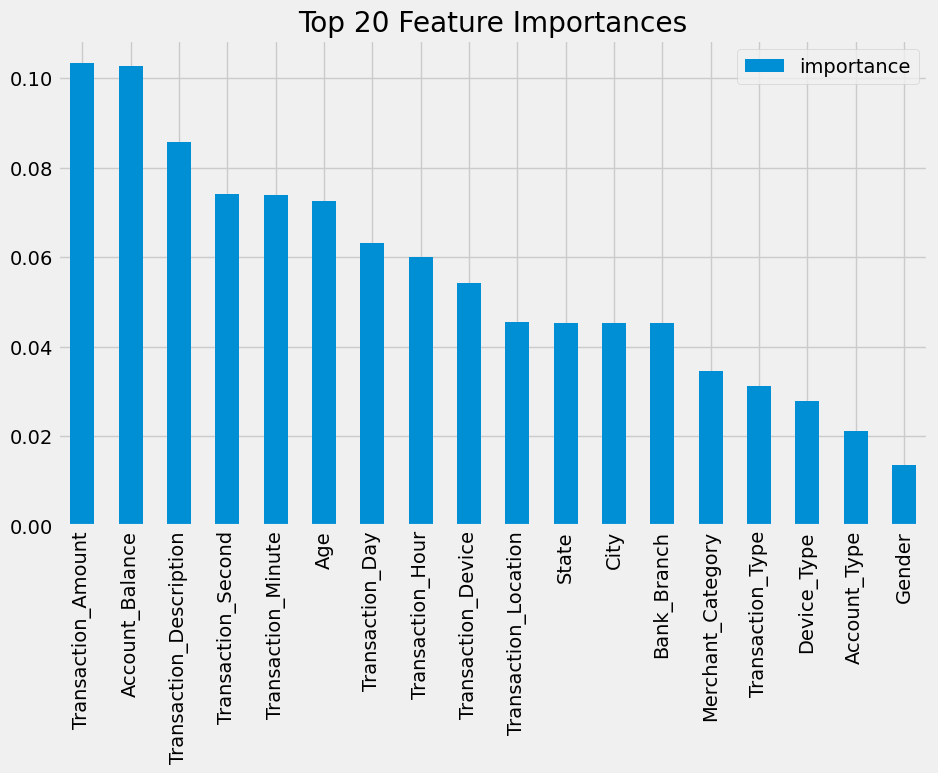

In [47]:
# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.head(20).plot(kind='bar', figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.show()

### SELECT ONLY IMPORTANT FEATURES

In [214]:
# Select features with importance greater than a threshold (e.g., 0.01)
important_features = feature_importances[feature_importances['importance'] > 0.01].index
X = df[important_features]
print("Shape for X Dataframe: ", X.shape)
print("Columns for X Dataframe: ", X.columns)

Shape for X Dataframe:  (200000, 18)
Columns for X Dataframe:  Index(['Transaction_Amount', 'Account_Balance', 'Transaction_Description',
       'Transaction_Second', 'Transaction_Minute', 'Age', 'Transaction_Day',
       'Transaction_Hour', 'Transaction_Device', 'Transaction_Location',
       'State', 'City', 'Bank_Branch', 'Merchant_Category', 'Transaction_Type',
       'Device_Type', 'Account_Type', 'Gender'],
      dtype='object')


### TRAIN TEST SPLIT

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling

In [224]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [226]:
model_1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=5)
model_1.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=5)

In [228]:
model_1_y_pred = model_1.predict(X_test_scaled)
report = classification_report(y_test, model_1_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37955
           1       0.00      0.00      0.00      2045

    accuracy                           0.95     40000
   macro avg       0.47      0.50      0.49     40000
weighted avg       0.90      0.95      0.92     40000



### HANDLING CLASS IMBALANCE

In [238]:
from imblearn.combine import SMOTETomek

tomek = SMOTETomek(random_state = 42)
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train_scaled, y_train)

print(y_train_tomek.value_counts())
print(y_train.value_counts())

Is_Fraud
0    151953
1    151953
Name: count, dtype: int64
Is_Fraud
0    151957
1      8043
Name: count, dtype: int64


In [239]:
tomek_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=5)
tomek_model.fit(X_train_tomek, y_train_tomek)

GradientBoostingClassifier(max_depth=5)

In [240]:
tomek_model_y_pred = tomek_model.predict(X_test_scaled)
report = classification_report(y_test, tomek_model_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37955
           1       0.00      0.00      0.00      2045

    accuracy                           0.95     40000
   macro avg       0.47      0.50      0.49     40000
weighted avg       0.90      0.95      0.92     40000



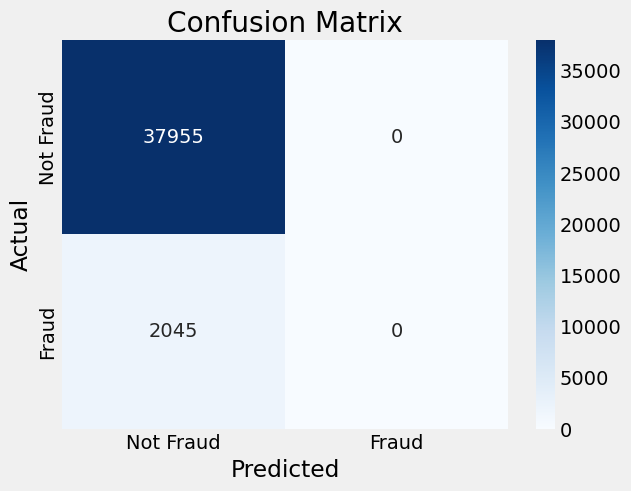

In [241]:
cm = confusion_matrix(y_test, tomek_model_y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',  
            xticklabels=['Not Fraud', 'Fraud'],  
            yticklabels=['Not Fraud', 'Fraud'])

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [242]:
tomek_model.score(X_test_scaled, y_test)

0.948875

In [252]:
X_train_tomek.shape

(303906, 18)

In [254]:
y_test.value_counts()

Is_Fraud
0    37955
1     2045
Name: count, dtype: int64

In [256]:
37955 + 2045

40000

In [258]:
37955/40000

0.948875

In [77]:
df.head()

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Description,Transaction_Day,Transaction_Hour,Transaction_Minute,Transaction_Second
0,1,60,15,127,127,2,32415.45,3,5,74557.27,17,129,3,0,9,23,16,4,7
1,0,51,18,100,100,0,43622.60,0,5,74622.66,9,102,1,0,65,11,17,14,53
2,1,20,4,13,13,2,63062.56,0,3,66817.99,0,13,1,0,102,25,3,9,52
3,0,57,28,22,22,0,14000.72,2,2,58177.08,8,24,2,0,51,19,12,27,2
4,0,43,25,7,7,2,18335.16,3,2,16108.56,16,7,2,0,37,30,18,30,46


In [79]:
new_df = df

In [81]:
new_df.drop(columns = ['Transaction_Description', 'Gender', 'Account_Type'], inplace=True, axis = 1)

In [94]:
new_df_majority = new_df[new_df['Is_Fraud'] == 0]
new_df_minority = new_df[new_df['Is_Fraud'] == 1]

# Downsample the majority class to match the size of the minority class
new_df_majority_downsampled = new_df_majority.sample(len(new_df_minority), random_state=42)

# Combine the downsampled majority class with the minority class
new_df_balanced = pd.concat([new_df_majority_downsampled, new_df_minority])

# Shuffle the balanced dataset
new_df_balanced = new_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print("Balanced Class Distribution:")
print(new_df_balanced['Is_Fraud'].value_counts())

Balanced Class Distribution:
Is_Fraud
1    10088
0    10088
Name: count, dtype: int64


In [102]:
new_df_balanced.sample(10)

,Age,State,City,Bank_Branch,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Day,Transaction_Hour,Transaction_Minute,Transaction_Second
11303,29,4,92,92,15027.48,0,2,27145.82,7,94,2,0,2,9,20,56
12100,40,7,33,33,65536.45,2,0,69481.86,13,35,3,1,10,17,29,1
14918,44,31,79,79,89845.72,1,4,42554.86,18,81,1,0,16,8,20,15
13400,63,0,19,19,61062.43,3,1,31071.94,10,19,0,0,17,3,34,2
19354,53,7,26,26,10612.74,0,2,27395.35,1,28,0,1,4,18,44,44
10761,48,20,104,104,58069.37,4,1,66868.69,0,106,2,0,6,2,21,46
10568,22,1,138,138,79311.76,0,3,68160.26,9,141,0,1,6,3,41,15
8179,21,18,91,91,19363.97,4,1,88316.46,1,93,1,0,2,17,9,14
12219,35,29,50,50,81197.16,3,1,28810.72,8,52,0,0,4,17,55,51
956,19,17,43,43,9502.98,4,4,43576.37,0,45,1,0,13,6,26,16


In [106]:
new_df_balanced.index = range(0, len(new_df_balanced))
new_df_balanced.head()

,Age,State,City,Bank_Branch,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Day,Transaction_Hour,Transaction_Minute,Transaction_Second
0,70,24,110,110,57046.99,2,0,31560.32,13,112,2,1,8,10,8,57
1,49,26,4,4,90382.89,0,3,70914.50,8,4,3,1,30,14,49,6
2,40,6,55,55,75252.54,3,3,78926.02,13,57,0,1,2,21,38,14
3,46,1,139,139,55053.91,0,3,31806.55,3,142,2,0,12,13,26,52
4,48,9,106,106,85865.70,2,3,38685.68,2,108,3,0,20,22,46,54


In [212]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

scaled_features = ['Age', 'Transaction_Amount', 'Account_Balance',
                   'Transaction_Day', 'Transaction_Hour', 'Transaction_Minute', 'Transaction_Second']

# Define other features (excluding 'Is_Fraud' and scaled features)
other_features = new_df_balanced.drop(columns=scaled_features + ['Is_Fraud'], axis = 1).columns.tolist()

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scaled_features),  # Scale numerical features
        ('passthrough', 'passthrough', other_features)  # Keep other features unchanged
    ]
)

# Define full pipeline (preprocessing + model)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())  # Model
])

In [214]:
X = new_df_balanced.drop(columns=['Is_Fraud'], axis = 1)  # Features
y = new_df_balanced['Is_Fraud']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

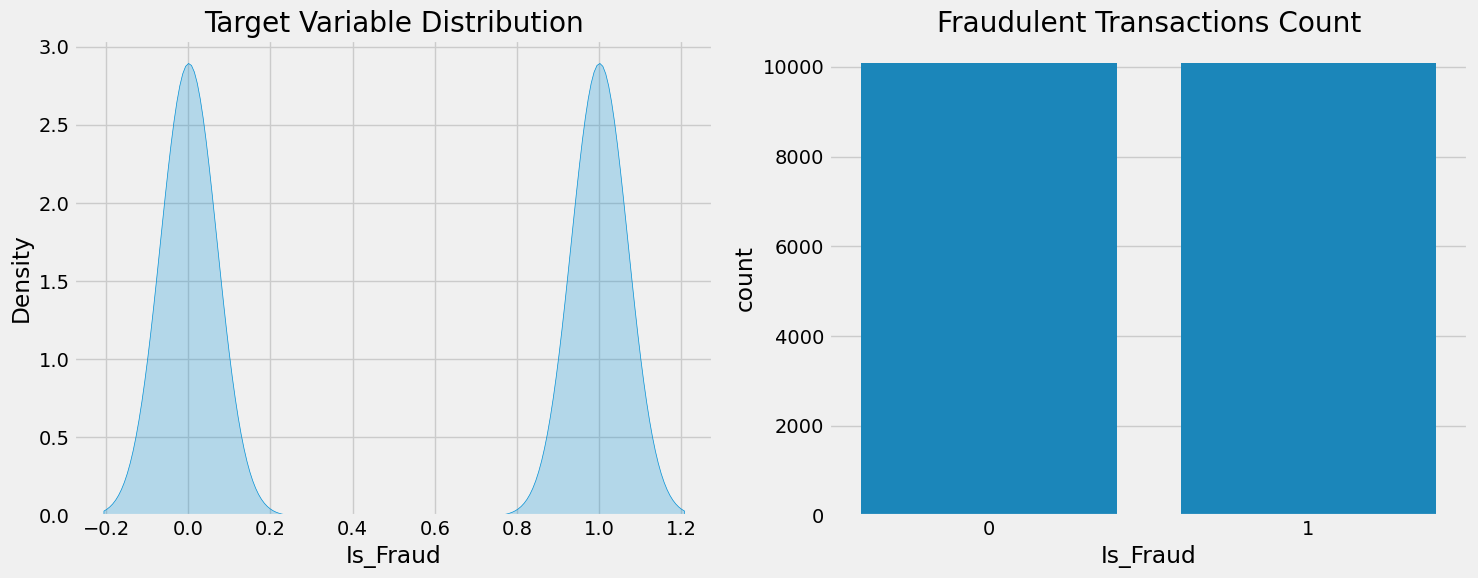

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# KDE plot for the 'Is_Fraud' column (on the first subplot)
sns.kdeplot(new_df_balanced["Is_Fraud"], fill=True, ax=axes[0])
axes[0].set_title('Target Variable Distribution')

# Count plot for the 'Is_Fraud' column (on the second subplot)
sns.countplot(x='Is_Fraud', data=new_df_balanced, ax=axes[1])
axes[1].set_title('Fraudulent Transactions Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [218]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Transaction_Amount',
                                                   'Account_Balance',
                                                   'Transaction_Day',
                                                   'Transaction_Hour',
                                                   'Transaction_Minute',
                                                   'Transaction_Second']),
                                                 ('passthrough', 'passthrough',
                                                  ['State', 'City',
                                                   'Bank_Branch',
                                                   'Transaction_Type',
                                                   'Merchant_Category',
                                                   'Transaction_Device',
                                                   'Transaction_Location',
                                                   'Device_Type'])])),
                ('classifier', GradientBoostingClassifier())])

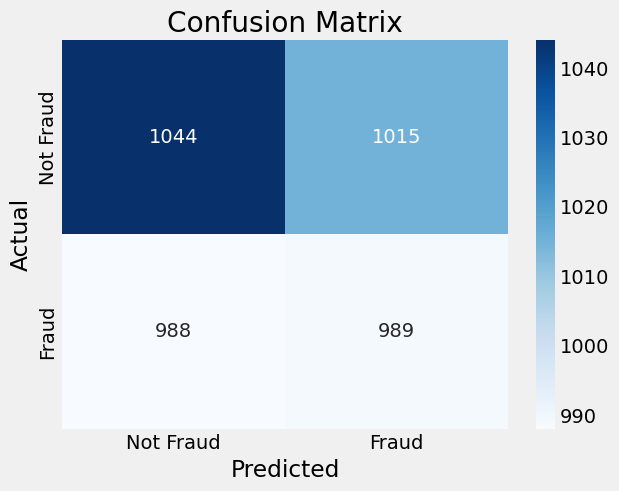

In [222]:
new_df_y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, new_df_y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',  
            xticklabels=['Not Fraud', 'Fraud'],  
            yticklabels=['Not Fraud', 'Fraud'])

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [224]:
pipeline.score(X_test,y_test)

0.5037165510406343

In [226]:
report = classification_report(y_test, new_df_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2059
           1       0.49      0.50      0.50      1977

    accuracy                           0.50      4036
   macro avg       0.50      0.50      0.50      4036
weighted avg       0.50      0.50      0.50      4036

